In [7]:
import pandas as pd

In [32]:
data = pd.read_csv("..\\preprocessed\\tweets_general.csv")
data.dropna(inplace=True)
print(data.shape)
data.head(2)

(24781, 3)


,tweet,tokens,label
0,woman shouldnt complain cleaning house man alw...,"['woman', 'shouldnt', 'complain', 'cleaning', ...",0
1,boy dat coldtyga dwn bad cuffin dat hoe st place,"['boy', 'dat', 'coldtyga', 'dwn', 'bad', 'cuff...",0


In [9]:
## check if tokenized column is the same as tweet to prepare for vectorization 
## not working. 

def check_token(row):
    tweet = row['tweet']
    tokens = row['tokens']
    words = tweet.split(' ')

    return len(tokens) == len(words) and all(token == word for token, word in zip(tokens, words))

data['is_token_correct'] = data.apply(lambda row: check_token(row), axis=1)

Vectorize text data

In [12]:
## libraries to be used

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [17]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['label'], test_size=0.2, random_state=42)

using both count vectorizer and tfidf to analyze performance

In [35]:
## check vocab size for reference, to help determine max features value for vectorizers 

vocab_file = '..\\custom_bert_tokenizer\\vocab.txt'
with open(vocab_file, 'r', encoding='utf-8') as f:
    vocab_size = sum(1 for _ in f)

max_features = min(vocab_size + 1000, 50000)  #  allow some extra room for unseen data
print(max_features, vocab_size)

16537 15537


In [36]:
# using the CountVectorizer
count_vectorizer = CountVectorizer(max_features=max_features)  
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)


In [38]:
# using the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)  
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


Train the model

In [39]:
## train log regression model on counts vectorized dataset
model_count = LogisticRegression()
model_count.fit(X_train_counts, y_train)

y_pred_counts = model_count.predict(X_test_counts)


In [40]:
# train the log regression model on tfidf vectorized dataset
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)


Evaluate the models

In [41]:
## evaluate model on count vectorizer 

# Calculate metrics
accuracy_counts = accuracy_score(y_test, y_pred_counts)
precision_counts = precision_score(y_test, y_pred_counts, average='binary')
recall_counts = recall_score(y_test, y_pred_counts, average='binary')
f1_counts = f1_score(y_test, y_pred_counts, average='binary')
roc_auc_counts = roc_auc_score(y_test, y_pred_counts)

# Print metrics
print(f'CountVectorizer - Accuracy: {accuracy_counts}')
print(f'CountVectorizer - Precision: {precision_counts}')
print(f'CountVectorizer - Recall: {recall_counts}')
print(f'CountVectorizer - F1 Score: {f1_counts}')
print(f'CountVectorizer - ROC AUC: {roc_auc_counts}')


CountVectorizer - Accuracy: 0.9412951381884204
CountVectorizer - Precision: 0.484375
CountVectorizer - Recall: 0.21602787456445993
CountVectorizer - F1 Score: 0.2987951807228916
CountVectorizer - ROC AUC: 0.600947556125913


In [42]:
## evaluaate on tfidf vectorizer 
# Calculate metrics
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
precision_tfidf = precision_score(y_test, y_pred_tfidf, average='binary')
recall_tfidf = recall_score(y_test, y_pred_tfidf, average='binary')
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='binary')
roc_auc_tfidf = roc_auc_score(y_test, y_pred_tfidf)

# Print metrics
print(f'TfidfVectorizer - Accuracy: {accuracy_tfidf}')
print(f'TfidfVectorizer - Precision: {precision_tfidf}')
print(f'TfidfVectorizer - Recall: {recall_tfidf}')
print(f'TfidfVectorizer - F1 Score: {f1_tfidf}')
print(f'TfidfVectorizer - ROC AUC: {roc_auc_tfidf}')


TfidfVectorizer - Accuracy: 0.9439176921525116
TfidfVectorizer - Precision: 0.576271186440678
TfidfVectorizer - Recall: 0.11846689895470383
TfidfVectorizer - F1 Score: 0.19653179190751446
TfidfVectorizer - ROC AUC: 0.5565567899484439


#### analysis 
both models seems to have decent accuracy and precision but terrible recall and f1 score, as well as non optimal roc auc curves. 

possible problem: there is a significant class imbalance 

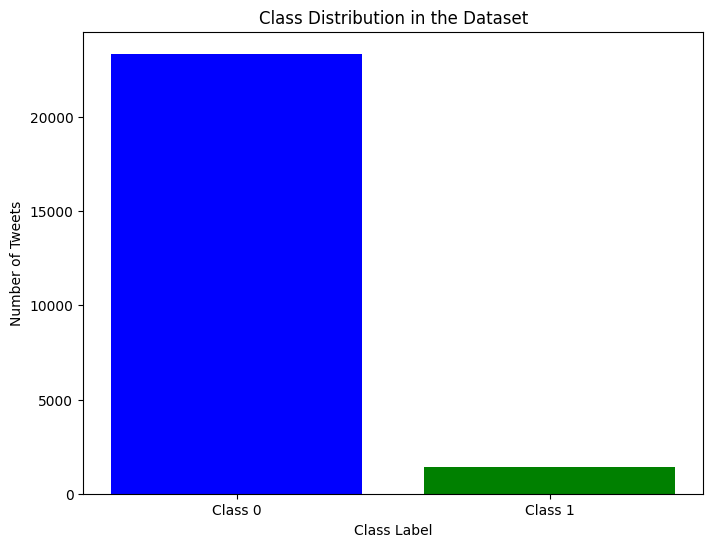

In [45]:
## visualizing the imbalance 
import matplotlib.pyplot as plt
df = pd.read_csv("..\\preprocessed\\tweets_general.csv")
class_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'green'])
plt.xticks(class_counts.index, ['Class 0', 'Class 1'])
plt.xlabel('Class Label')
plt.ylabel('Number of Tweets')
plt.title('Class Distribution in the Dataset')
plt.show()


that's pretty bad. <br> we should undersample the data. it would drastically lower our dataset -- possible other solutions would be to:

    a) change our dataset
    b) change the definition of hatespeech (i.e. offensive speech could also be considered hatespeech)

In [59]:
## undersampling dataset 
data.dropna(inplace=True)

# Separate majority and minority classes
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

df_majority_undersampled = df_majority.sample(len(df_minority), random_state=42)
df_balanced = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced.dropna(inplace=True)

print(df_balanced['label'].value_counts())
df_balanced.head(2)

label
1    1430
0    1429
Name: count, dtype: int64


,tweet,tokens,label
0,gay stfu dumb monkey,"['gay', 'stfu', 'dumb', 'monkey']",1
1,yes im white washed dont go around repping hoo...,"['yes', 'im', 'white', 'washed', 'dont', 'go',...",1


In [60]:
## redo previous steps (vectorizing, training and evaluation.)

Vectorize text data

In [61]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_balanced['tweet'], df_balanced['label'], test_size=0.2, random_state=42)

using both count vectorizer and tfidf to analyze performance

In [62]:
## check vocab size for reference, to help determine max features value for vectorizers 

vocab_file = '..\\custom_bert_tokenizer\\vocab.txt'
with open(vocab_file, 'r', encoding='utf-8') as f:
    vocab_size = sum(1 for _ in f)

max_features = min(vocab_size + 1000, 50000)  #  allow some extra room for unseen data
print(max_features, vocab_size)

16537 15537


In [63]:
# using the CountVectorizer
count_vectorizer = CountVectorizer(max_features=max_features)  
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)


In [64]:
# using the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)  
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


Train the model

In [65]:
## train log regression model on counts vectorized dataset
model_count = LogisticRegression()
model_count.fit(X_train_counts, y_train)

y_pred_counts = model_count.predict(X_test_counts)


In [66]:
# train the log regression model on tfidf vectorized dataset
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)


Evaluate the models

In [67]:
## evaluate model on count vectorizer 

# Calculate metrics
accuracy_counts = accuracy_score(y_test, y_pred_counts)
precision_counts = precision_score(y_test, y_pred_counts, average='binary')
recall_counts = recall_score(y_test, y_pred_counts, average='binary')
f1_counts = f1_score(y_test, y_pred_counts, average='binary')
roc_auc_counts = roc_auc_score(y_test, y_pred_counts)

# Print metrics
print(f'CountVectorizer - Accuracy: {accuracy_counts}')
print(f'CountVectorizer - Precision: {precision_counts}')
print(f'CountVectorizer - Recall: {recall_counts}')
print(f'CountVectorizer - F1 Score: {f1_counts}')
print(f'CountVectorizer - ROC AUC: {roc_auc_counts}')


CountVectorizer - Accuracy: 0.7797202797202797
CountVectorizer - Precision: 0.7544483985765125
CountVectorizer - Recall: 0.7881040892193308
CountVectorizer - F1 Score: 0.7709090909090909
CountVectorizer - ROC AUC: 0.7801906584710516


In [68]:
## evaluaate on tfidf vectorizer 
# Calculate metrics
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
precision_tfidf = precision_score(y_test, y_pred_tfidf, average='binary')
recall_tfidf = recall_score(y_test, y_pred_tfidf, average='binary')
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='binary')
roc_auc_tfidf = roc_auc_score(y_test, y_pred_tfidf)

# Print metrics
print(f'TfidfVectorizer - Accuracy: {accuracy_tfidf}')
print(f'TfidfVectorizer - Precision: {precision_tfidf}')
print(f'TfidfVectorizer - Recall: {recall_tfidf}')
print(f'TfidfVectorizer - F1 Score: {f1_tfidf}')
print(f'TfidfVectorizer - ROC AUC: {roc_auc_tfidf}')


TfidfVectorizer - Accuracy: 0.791958041958042
TfidfVectorizer - Precision: 0.7568493150684932
TfidfVectorizer - Recall: 0.8215613382899628
TfidfVectorizer - F1 Score: 0.7878787878787878
TfidfVectorizer - ROC AUC: 0.7936189529733642


#### analysis 

TfidfVectorizer is the better choice between the two this task. It achieves higher recall, F1 score, and ROC AUC, which are critical for effectively identifying hate speech tweets while minimizing false positives.